In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, chi2, SelectKBest

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from sklearn import metrics
from matplotlib.colors import LinearSegmentedColormap
from sklearn.inspection import permutation_importance

from IPython.display import display
import warnings

# Pre-processing

## Remove text data and rate

In [2]:
def remove_data(df):
    """
    remove columns with text
    
    df: dataframe of articles
    """
    
    df.drop(['title', 'text', 'rate', 'clean_text'], axis=1, inplace = True)
    return df

In [3]:
def cat_to_num(df):
    """
    convert categorical value to numerical
    
    df: dataframe of articles
    """
    
    # order of the number does matter
    importance = {'Top': 1,
                  'High': 2,
                  'Mid': 3,
                  'Low': 4,
                  'Bottom': 5,
                  'Unknown': 6}
    classes = {'High': 1, 'Low': 0}

    df['2_classes'] = df['2_classes'].map(classes)
    df['importance'] = df['importance'].map(importance)
    return df

## Split Data

In [4]:
def split_data(df):
    """
    split data into 70%/30% for modelling
    
    df: dataframe of articles
    """

    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1] # last column is the 2_class which is the dependent variable

    # use stratify so train and test set have same distribution of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Feature Selection

In [5]:
def feature_selection(X_train, y_train, X_test):
    """
    select 10 features from numerical features
    
    X_train: independent variables from train set
    y_train: dependent variable from train set
    X_test: independent variables from test set
    """
    
    numerical_features= [feature for feature in list(X_train.columns) 
                         if feature != 'importance']

    # use ANOVA correlation coefficient to select top 10 features
    fs = SelectKBest(score_func=f_classif, k=10)
    X_train_fs = fs.fit_transform(X_train[numerical_features], y_train)
    X_test_fs = fs.transform(X_test[numerical_features])
    
    selected_features = [value for value, flag in zip(numerical_features, fs.get_support()) if flag]
    
    X_train_fs = pd.DataFrame(X_train_fs, columns=selected_features)
    X_test_fs = pd.DataFrame(X_test_fs, columns=selected_features)
    
    return X_train_fs, X_test_fs, fs

## Visualise ANOVA coefficient

In [6]:
def visualise_feature_selection(fs, numerical_features):
    """
    bar chart for the ANOVA correlation coefficient
    
    fs: object that select K best using certain score function
    numerical_features: all numerical feature name
    """
    
    p_values = fs.pvalues_
    significant = p_values < 0.05
    for i, (score, is_significant) in enumerate(zip(fs.scores_, significant)):
        print(f"{numerical_features[i]}: {score:.4f} - {'significant' if is_significant else 'not significant'}")

    bars = plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.xticks(range(len(numerical_features)), numerical_features, 
               rotation=45, ha='right', rotation_mode='anchor')

    # create text to show score
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                 ha='center', va='bottom', fontsize=8)
    plt.show()
    
    selected_features = [value for value, flag in zip(numerical_features, fs.get_support()) if flag]
    print(selected_features)

# Modelling

In [7]:
def modelling(algorithm, X_train, X_test, y_train, y_test):
    """
    train classification model
    
    algorithm: the model used for classification
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    """
    
    # create a pipeline to normalise value before building model
    pipe = Pipeline([("scaler", MinMaxScaler()),
                     ("model", algorithm)])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classifier accuracy: {accuracy:.2f}")
    
    return pipe.steps[1][1], y_pred, y_proba

# Feature Importance

In [8]:
def plot_importance(algo_name, model, X_test, y_test, feature_names):
    """
    bar chart for the importance of each features in the model
    
    algo_name: the name of the model used for classification
    model: the trained classification model
    X_test: independent variables from test set
    y_test: dependent variable from test set
    feature_names: name of all features used in classification
    """
    
    # Naive Bayes does not have built-in feature importance so need to use permutation importance
    if algo_name == "Naive Bayes":
        results = permutation_importance(model, X_test, y_test, scoring='f1', n_jobs = -1)
        importance = results.importances_mean
        print(importance)
    # Logistic Regression has coefficient to show how change in feature value impact the result
    elif algo_name in ["Logistic Regression"]:
        importance = model.coef_[0]
    # K-Nearest Neighbors and Support Vector Machine cannot calculate feature importance
    elif algo_name in ["K-Nearest Neighbors", "Support Vector Machine"]:
        return
    # Decision Tree and Random Forest has built-in feature importance
    else:
        try:
            importance = model.feature_importances_
        except AttributeError:
            warnings.warn(f"The model {algo_name} does not support feature importances.")
    
    plt.title(f"Feature Importance in {algo_name}")
    bars = plt.bar(range(len(importance)), importance)
    plt.xticks(range(len(importance)), feature_names, rotation=90)
    
    # create text to show feature importance score
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                 ha='center', va='bottom', fontsize=8)
        
    plt.show()

# Measure Performance

## Performance Matrix

In [9]:
def performance_matrix(y_test, y_pred, y_proba):
    """
    calculate multiple performance matrix
    
    y_test: dependent variable from test set
    y_pred: predicted category of test set
    y_proba: predicted probability of test set
    """
    
    accuracy = round(accuracy_score(y_test, y_pred),2)
    precision = round(precision_score(y_test, y_pred),2) # propotion of positive predictions was actually correct
    recall = round(recall_score(y_test, y_pred),2) # proportion of actual positives was identified correctly
    f1 = round(f1_score(y_test, y_pred),2)
    auc = round(roc_auc_score(y_test, y_proba),2)
    
    metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1 Score'],
                               'Value': [accuracy, precision, recall, auc, f1]})
    display(metrics_df)

## Confusion Matrix

In [10]:
def visualise_conf_max(y_test, y_pred, algo_name, balance = False, save = False):
    """
    draw confusion matrix
    
    y_test: dependent variable from test set
    y_pred: predicted category of test set
    algo_name: the name of the model used for classification
    balance: whether dataset is balance
    save: whether to save the plot
    """
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    reversed_confusion_matrix = confusion_matrix[::-1, ::-1]
    colors = ["#C35F4A", "#EEF6F0", "#FFB03A"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_red_blue", colors)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = reversed_confusion_matrix, 
                                                display_labels=['High', 'Low'])

    ax = cm_display.plot(cmap=custom_cmap, colorbar=False)
    if balance:
        title = "Balance Class"
    else:
        title = "Imbalance Class"
    ax.ax_.set_title(f'Confusion Matrix for {title}', fontdict={"fontsize":20})

    # adjust display of the text
    for text in ax.ax_.texts:
        text.set_fontsize(20)
        text.set_color('black') 
        text.set_fontweight('bold')

    # add gridline for confusion matrix
    ax.ax_.axhline(y=0.5, color='black', linewidth=1)
    ax.ax_.axvline(x=0.5, color='black', linewidth=1)
    
    ax.ax_.set_xlabel('Predicted label', fontsize=20)
    ax.ax_.set_ylabel('True label', fontsize=20)

    ax.ax_.tick_params(axis='both', which='major', labelsize=18)

    # save image
    if save and balance:
        image_name = "Confusion Matrix (Balance)"
        plt.savefig(f"Poster/{algo_name}_{image_name}", dpi=1000, bbox_inches='tight', transparent=True)
    elif save and not balance:
        image_name = "Confusion Matrix (Imbalance)"
        plt.savefig(f"Poster/{algo_name}_{image_name}", dpi=1000, bbox_inches='tight', transparent=True)
    plt.show()

## ROC Curve

In [11]:
def visualise_roc_curve(result_proba):
    """
    ROC curve for all model
    
    result_proba: dictionary of model name and predicted probability
    """
    
    for name, y_proba in result_proba.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Classifiers')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def prepare_data(df):
    """
    Prepare the data before building classification model
    
    df: dataframe of articles
    """
    
    df = remove_data(df)
    df = cat_to_num(df)
    X_train, X_test, y_train, y_test = split_data(df)
    
    return df, X_train, X_test, y_train, y_test

In [13]:
algorithms = {"Naive Bayes": GaussianNB(),
              "Logistic Regression": LogisticRegression(), 
              "K-Nearest Neighbors": KNeighborsClassifier(), 
              "Support Vector Machine": SVC(probability=True), 
              "Decision Tree": DecisionTreeClassifier(), 
              "Random Forest": RandomForestClassifier()}

def prediction_analysis(df, X_train, X_test, y_train, y_test, algo_name, balance = False):
    """
    build classification model and visualise result
    
    df: dataframe of articles
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    algo_name: the name of the model used for classification
    balance: whether dataset is balance
    """
    
    feature_names = X_train.columns
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
    
    model, y_pred, y_proba = modelling(algorithms[algo_name], 
                                       X_train, X_test, y_train, y_test)
    
    performance_matrix(y_test, y_pred, y_proba)
    
    visualise_conf_max(y_test, y_pred, algo_name, balance = False)
    
    plot_importance(algo_name, model, X_test, y_test, feature_names)
    
    return y_proba

# Imbalance Data

In [14]:
df = pd.read_csv(f'../Data/grouped_dataset_(Imbalance).csv', keep_default_na=False)

In [15]:
df, X_train, X_test, y_train, y_test = prepare_data(df)

## Feature selection

reference: 792.8690 - significant
external_link: 418.0897 - significant
internal_link: 478.1667 - significant
table: 1.5591 - not significant
formula: 0.0819 - not significant
images: 126.9320 - significant
section: 184.9695 - significant
subsection: 258.3187 - significant
subsubsection: 8.0925 - significant
paragraph: 239.6426 - significant
sentence: 928.5431 - significant
flesch: 24.1558 - significant
flesch_kincaid: 7.9514 - significant
smog_index: 2.3090 - not significant
coleman_liau: 8.1708 - significant
automated_readability: 1.4929 - not significant
difficult_words: 911.4072 - significant
dale_chall: 408.3450 - significant
linsear: 1.4584 - not significant
gunning_fog: 62.8735 - significant


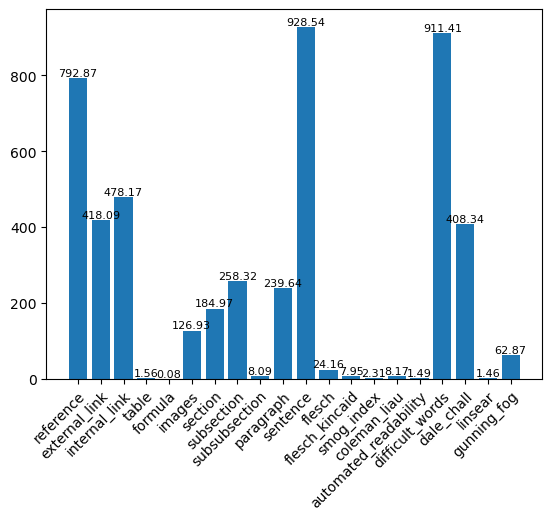

['reference', 'external_link', 'internal_link', 'images', 'section', 'subsection', 'paragraph', 'sentence', 'difficult_words', 'dale_chall']


In [16]:
X_train_fs, X_test_fs, fs = feature_selection(X_train, y_train, X_test)

numerical_features = [feature for feature in list(X_train.columns) if feature != 'importance']

# concatenate categorical feature back to selected numerical features
X_train = pd.concat([X_train_fs, X_train['importance'].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_fs, X_test['importance'].reset_index(drop=True)], axis=1)

visualise_feature_selection(fs, numerical_features)

## Naive Bayes

Classifier accuracy: 0.82


,Metric,Value
0,Accuracy,0.82
1,Precision,0.19
2,Recall,0.51
3,AUC,0.80
4,F1 Score,0.28


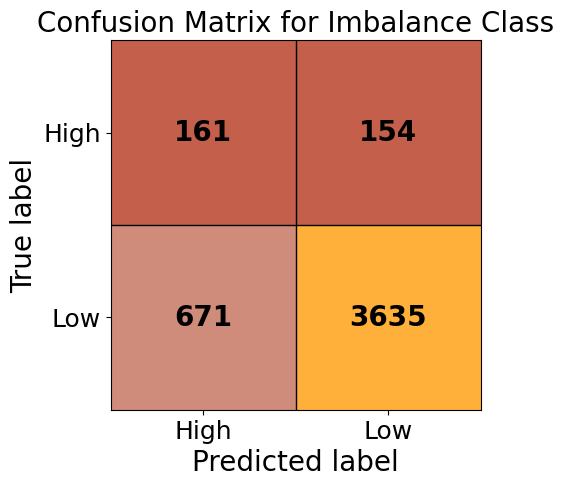

[ 6.35779657e-03  7.09323635e-03  7.63557217e-03 -1.14344837e-02
 -1.98868708e-03 -4.27739427e-05 -1.19541164e-02  7.41684631e-03
  8.09721104e-03  1.42650055e-03  0.00000000e+00]


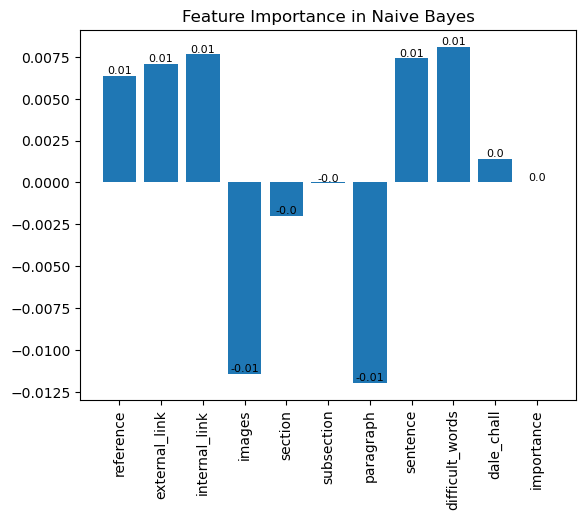

In [17]:
nb_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Naive Bayes")

## Logistic Regression

Classifier accuracy: 0.93


,Metric,Value
0,Accuracy,0.93
1,Precision,0.37
2,Recall,0.04
3,AUC,0.86
4,F1 Score,0.07


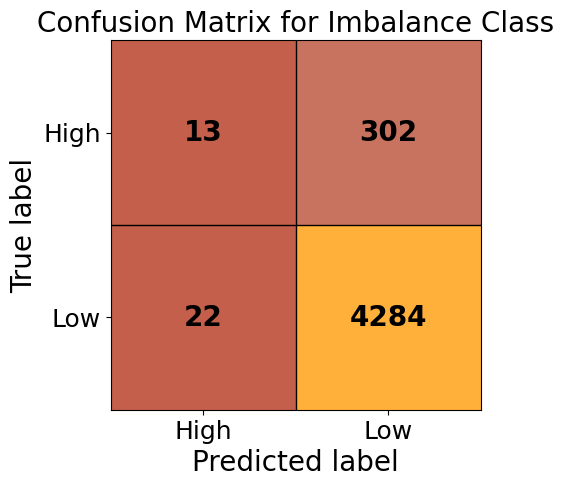

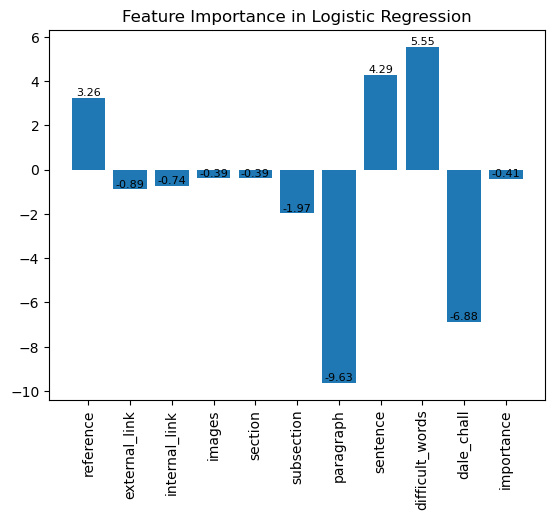

In [18]:
lr_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Logistic Regression")

## K-Nearest Neighbors

Classifier accuracy: 0.94


,Metric,Value
0,Accuracy,0.94
1,Precision,0.59
2,Recall,0.20
3,AUC,0.77
4,F1 Score,0.30


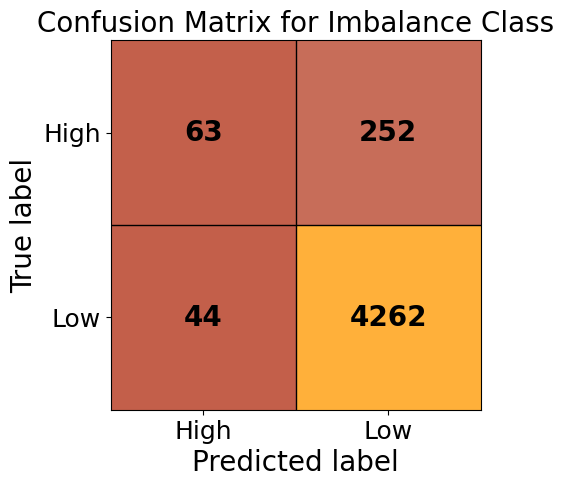

In [19]:
knn_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "K-Nearest Neighbors")

## Support Vector Machine

Classifier accuracy: 0.93


,Metric,Value
0,Accuracy,0.93
1,Precision,1.00
2,Recall,0.01
3,AUC,0.78
4,F1 Score,0.03


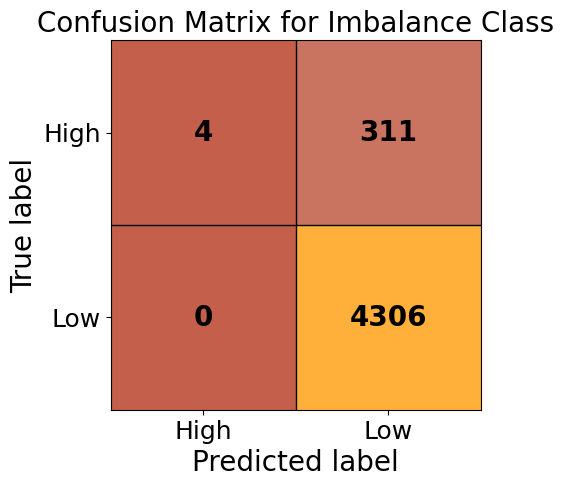

In [20]:
svm_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Support Vector Machine")

## Decision Tree

Classifier accuracy: 0.90


,Metric,Value
0,Accuracy,0.90
1,Precision,0.29
2,Recall,0.32
3,AUC,0.63
4,F1 Score,0.31


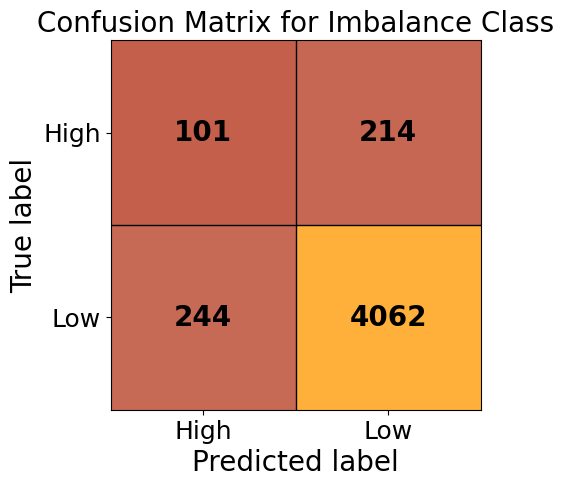

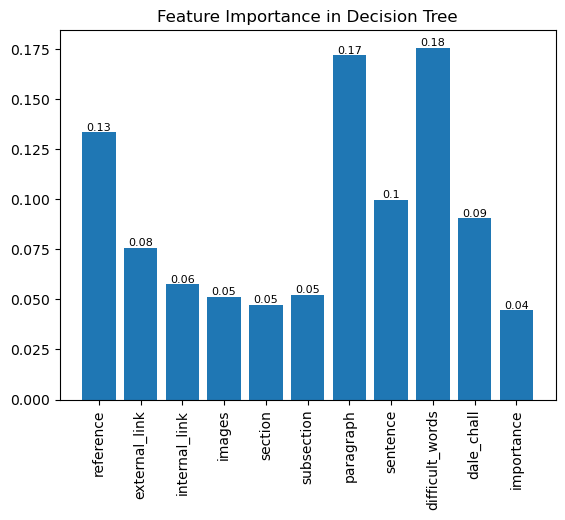

In [21]:
dt_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Decision Tree")

## Random Forest

Classifier accuracy: 0.94


,Metric,Value
0,Accuracy,0.94
1,Precision,0.66
2,Recall,0.17
3,AUC,0.90
4,F1 Score,0.28


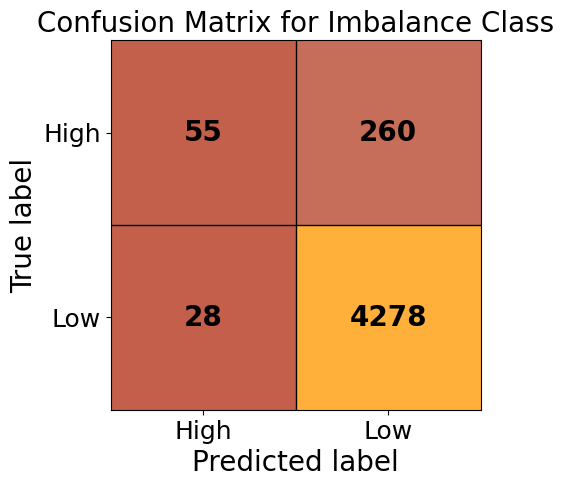

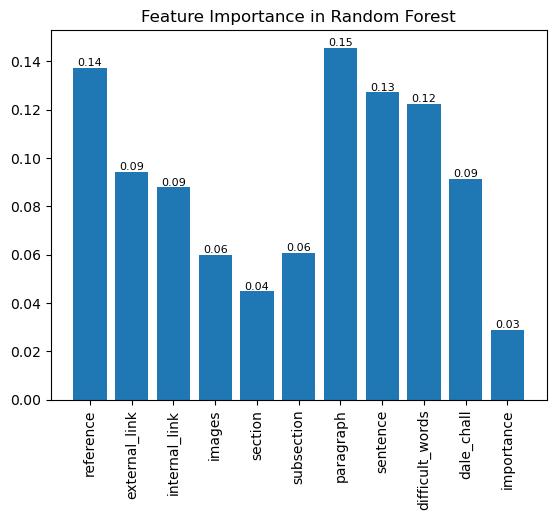

In [22]:
rf_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Random Forest")

## ROC Curve

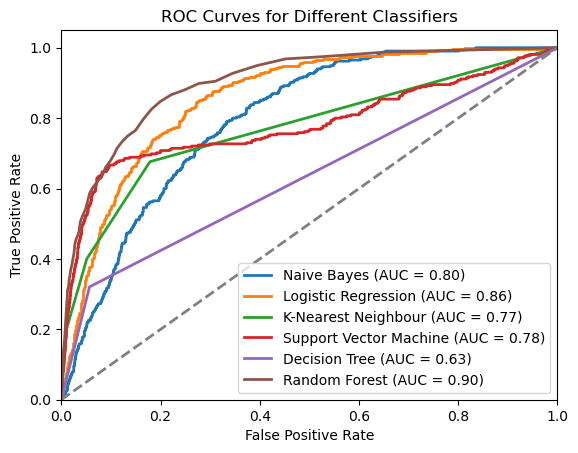

In [23]:
result_proba = {"Naive Bayes": nb_y_proba,
                "Logistic Regression": lr_y_proba, 
                "K-Nearest Neighbour": knn_y_proba, 
                "Support Vector Machine": svm_y_proba, 
                "Decision Tree": dt_y_proba, 
                "Random Forest": rf_y_proba}

visualise_roc_curve(result_proba)

# Balance Data

In [24]:
df = pd.read_csv(f'../Data/grouped_dataset_(Balance).csv', keep_default_na=False)

In [25]:
df, X_train, X_test, y_train, y_test = prepare_data(df)

## Feature Selection

reference: 30.2630 - significant
external_link: 336.4444 - significant
internal_link: 262.6033 - significant
table: 43.9524 - significant
formula: 1.0512 - not significant
images: 364.0475 - significant
section: 136.2584 - significant
subsection: 430.9093 - significant
subsubsection: 285.0880 - significant
paragraph: 194.1508 - significant
sentence: 211.1092 - significant
flesch: 1646.6365 - significant
flesch_kincaid: 315.4650 - significant
smog_index: 554.9547 - significant
coleman_liau: 1430.9395 - significant
automated_readability: 150.7528 - significant
difficult_words: 66.8242 - significant
dale_chall: 2553.7711 - significant
linsear: 131.7938 - significant
gunning_fog: 512.7703 - significant


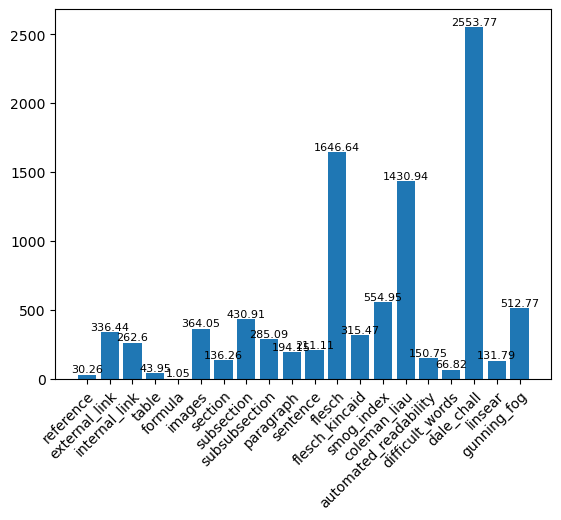

['external_link', 'images', 'subsection', 'subsubsection', 'flesch', 'flesch_kincaid', 'smog_index', 'coleman_liau', 'dale_chall', 'gunning_fog']


In [26]:
X_train_fs, X_test_fs, fs = feature_selection(X_train, y_train, X_test)

numerical_features = [feature for feature in list(X_train.columns) if feature != 'importance']

# concatenate categorical feature back to selected numerical features
X_train = pd.concat([X_train_fs, X_train['importance'].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_fs, X_test['importance'].reset_index(drop=True)], axis=1)

visualise_feature_selection(fs, numerical_features)

## Naive Bayes

Classifier accuracy: 0.81


,Metric,Value
0,Accuracy,0.81
1,Precision,0.74
2,Recall,0.95
3,AUC,0.93
4,F1 Score,0.83


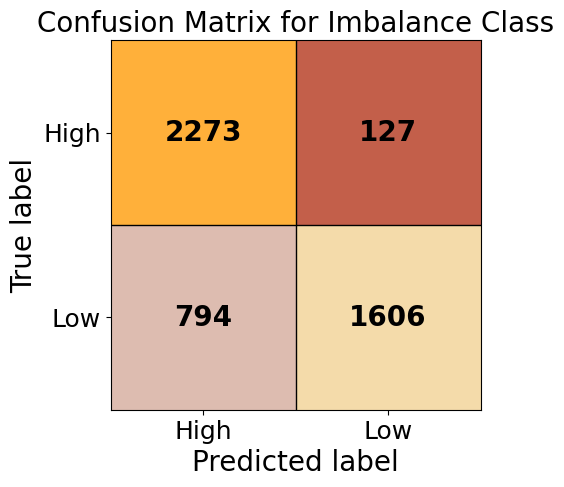

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


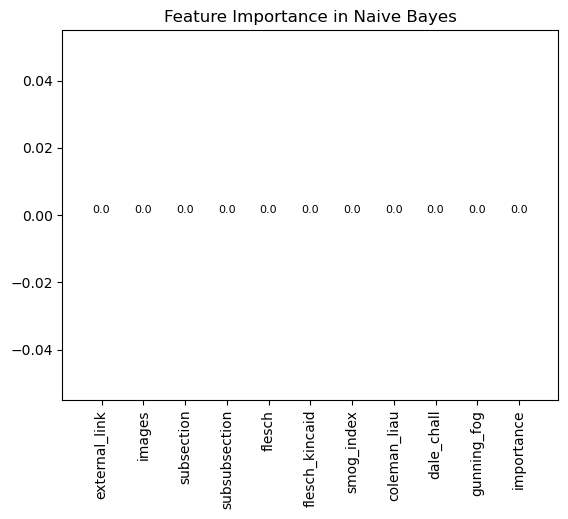

In [27]:
nb_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Naive Bayes")

## Logistic Regression

Classifier accuracy: 0.86


,Metric,Value
0,Accuracy,0.86
1,Precision,0.82
2,Recall,0.91
3,AUC,0.93
4,F1 Score,0.87


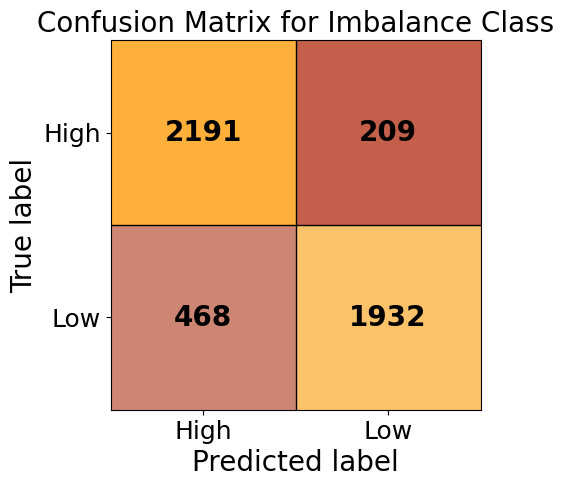

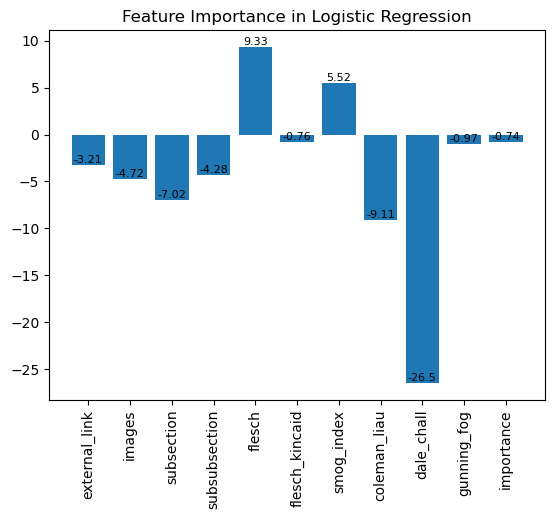

In [28]:
lr_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Logistic Regression")

## K-Nearest Neighbors

Classifier accuracy: 0.91


,Metric,Value
0,Accuracy,0.91
1,Precision,0.91
2,Recall,0.92
3,AUC,0.96
4,F1 Score,0.91


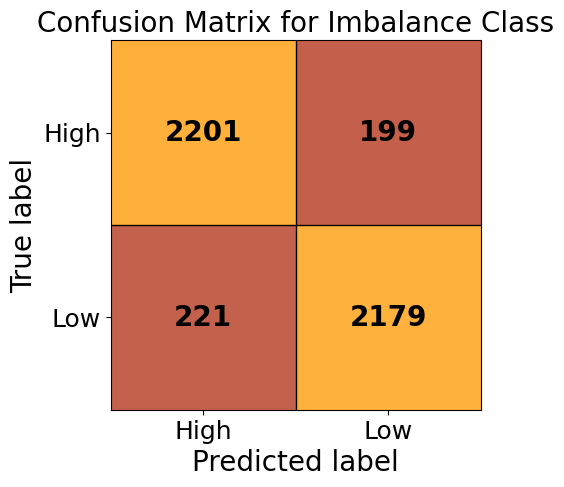

In [29]:
knn_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "K-Nearest Neighbors")

## Support Vector Machine

Classifier accuracy: 0.90


,Metric,Value
0,Accuracy,0.90
1,Precision,0.91
2,Recall,0.90
3,AUC,0.97
4,F1 Score,0.90


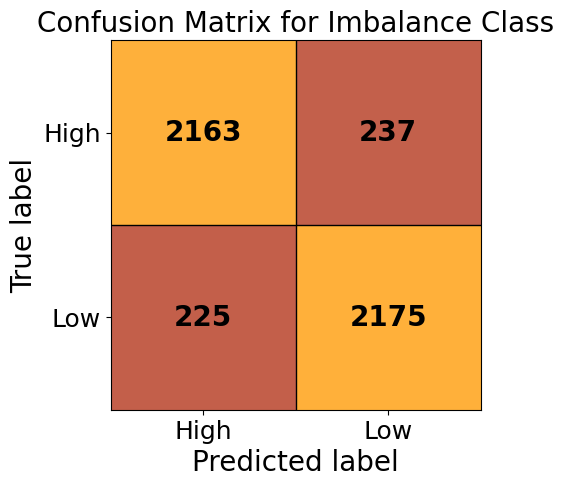

In [30]:
svm_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Support Vector Machine")

## Decision Tree

Classifier accuracy: 0.93


,Metric,Value
0,Accuracy,0.93
1,Precision,0.95
2,Recall,0.92
3,AUC,0.93
4,F1 Score,0.93


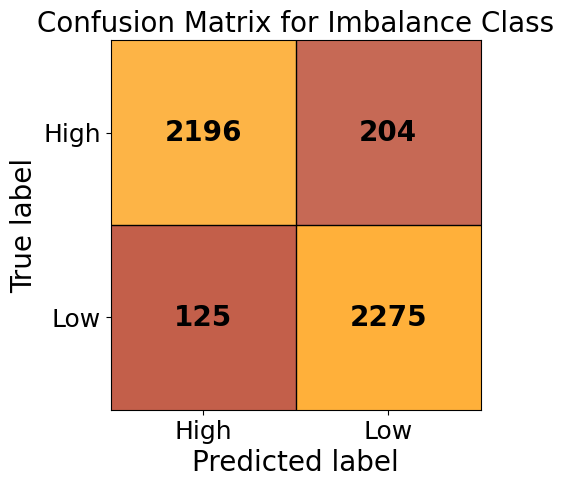

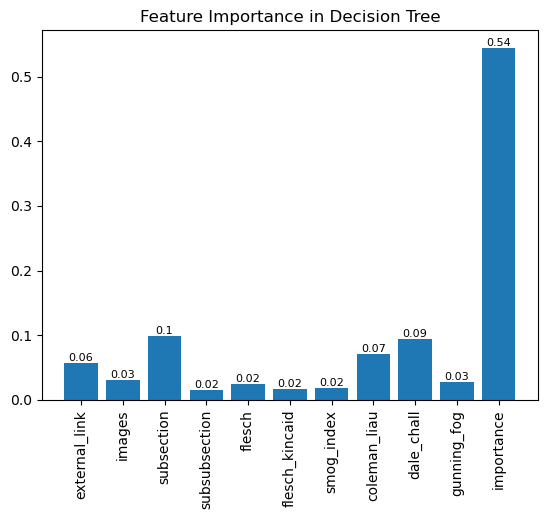

In [31]:
dt_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Decision Tree")

## Random Forest

Classifier accuracy: 0.96


,Metric,Value
0,Accuracy,0.96
1,Precision,0.97
2,Recall,0.95
3,AUC,0.99
4,F1 Score,0.96


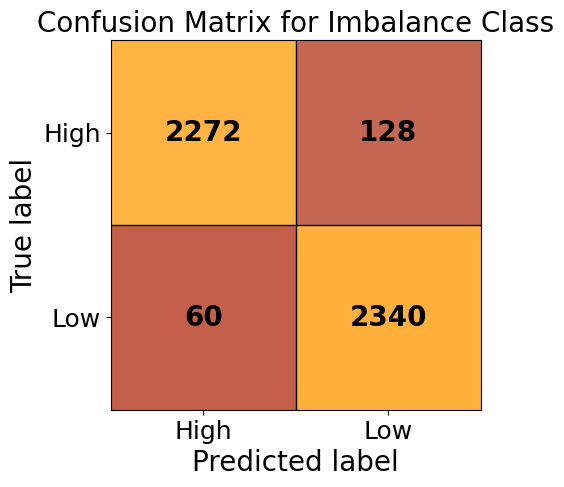

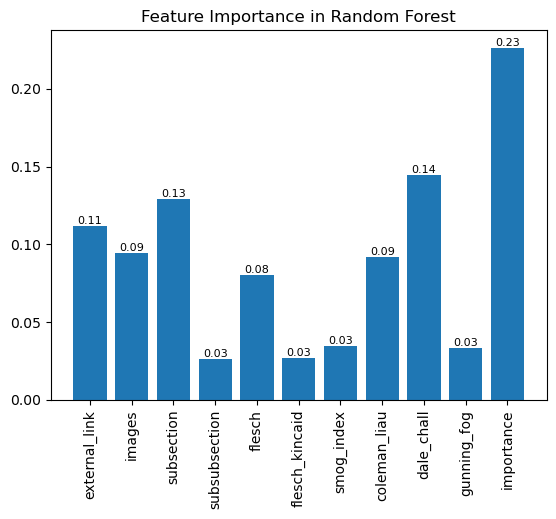

In [32]:
rf_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Random Forest")

## ROC Curve

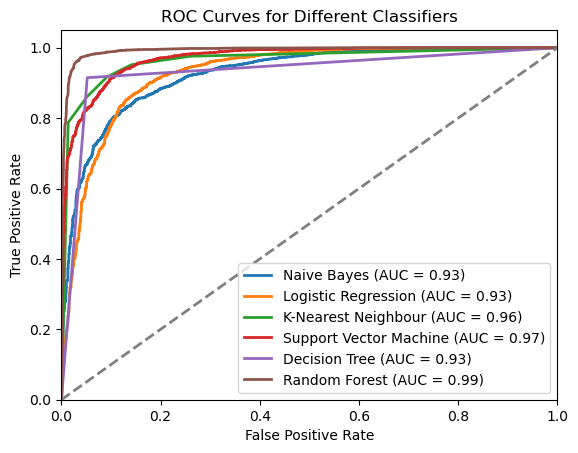

In [33]:
result_proba = {"Naive Bayes": nb_y_proba,
                "Logistic Regression": lr_y_proba, 
                "K-Nearest Neighbour": knn_y_proba, 
                "Support Vector Machine": svm_y_proba, 
                "Decision Tree": dt_y_proba, 
                "Random Forest": rf_y_proba}

visualise_roc_curve(result_proba)